# Построение ML-продукта для предсказания повторной покупки покупателя
**Описание проекта**
<br>Предоставлено три файла - каждый файл это отдельный интернет-магазин:
- `marketplace` – мультикатегорийный магазин с посещаемостью более 8-ми млн сессий в месяц, 
- `apparel` – магазин одежды, по характеристикам похожий на маркетплейс, 
- `gifts` - очень маленький магазин подарков.

<br>В данных - обезличенная история покупок клиентов за определенный период.

**Цель проекта**
- Необходимо создать решение для предсказания совершения покупателем повторной покупки в течение ближайших 30-ти дней 

**Задачи**
- Необходимо выбрать и обосновать метрику (Заказчику важен положительный класс покупателей),
- предложить решение, способное с высокой вероятностью предсказывать поведение клиентов.

**Ход исследования**
- загрузка данных и ознакомление с ними,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- подготовка данных для обучения,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- отчёт по проведённому исследованию.

**Описание данных**
<br>`client_id` - идентификатор клиента,
<br>`quantity` - количество товара в заказе,
<br>`price` - цена единицы товара в заказе,
<br>`message_id` - идентификатор сообщения из рассылки,
<br>`date` - дата покупки

**Выбор метрик**
- данная задача является задачей классификации,
  <br>ориентированная на временные ряды,
- метрики для оптимизации будут выбраны после ознакомления с данными,
- предварительно - `ROC-AUC`

## Настройка рабочей среды

In [1]:
# !pip list
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install pyarrow
# !pip install phik
# !pip install statsmodels
# !pip install scikit-learn
# !pip install prophet
# !pip install ipywidgets plotly
# !pip install catboost

In [2]:
import pandas as pd

### Импорт своего класса

In [3]:
from research_class import DatasetExplorer

## Загрузка и первичный EDA

In [4]:
try:
    marketplace = pd.read_csv('data/marketplace-purchases.csv', parse_dates=['date', 'created_at'])
    apparel = pd.read_csv('data/apparel-purchases.csv', parse_dates=['date'])
    gifts = pd.read_csv('data/gifts-purchases.csv', parse_dates=['date'])
    print('загружено из каталога "data"')
except:
    marketplace = pd.read_csv(userdata.get('marketplace_path'), parse_dates=['date', 'created_at'])
    apparel = pd.read_csv(userdata.get('apparel_path'), parse_dates=['date'])
    gifts = pd.read_csv(userdata.get('gifts_path'), parse_dates=['date'])
    print('загружено из каталога Google Drive')

загружено из каталога "data"


### Holidays
Загружено с сайта [xmlcalendar.ru](https://xmlcalendar.ru)

In [5]:
years = [2022, 2023]
holidays_dict = {}

for year in years:
    url = f'https://xmlcalendar.ru/data/ru/{year}/calendar.csv'
    holidays_dict[f'{year}'] = pd.read_csv(url)
print('данные успешно загружены')

данные успешно загружены


In [6]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [7]:
holidays = pd.DataFrame()

for year, year_str in zip(years, holidays_dict.keys()):
    holidays_year = date_preparation(holidays_dict[year_str], year)
    holidays = pd.concat([holidays, holidays_year], ignore_index=True)

holidays.sample(5)

Год/Месяц,year,month,day,date
210,2023,9,23,2023-09-23
35,2022,4,2,2022-04-02
64,2022,6,25,2022-06-25
50,2022,5,10,2022-05-10
117,2022,12,18,2022-12-18


#### Выводы и наблюдения
- подготовлен датасет, в котором перечислены все выходные и праздничные дни в РФ в 2022 и 2023 годах

### Marketplace

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
11000,1515915625517837941,1,1049.0,1515915625517837941-1969-64b0c6fe90a14,2023-07-14,2023-07-14 04:08:13
24273,1515915625584907501,1,25198.0,1515915625518579668-2114-650bc1038c372,2023-09-21,2023-09-21 09:31:10
36109,1515915625517597167,1,10000.0,1515915625519016994-1686-6430f18a1c789,2023-04-08,2023-04-08 06:59:09
25634,1515915625516108651,1,245.0,1515915625516108651-2011-64c8ee2a8b2cc,2023-08-06,2023-08-06 09:00:34
41395,1515915625561929589,1,119996.0,1515915625561929589-1276-6375d87b2fa1f,2022-11-17,2022-11-17 07:08:32


количество полных дубликатов строк: 2159


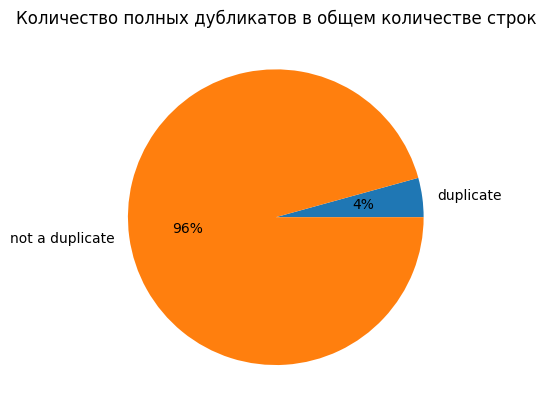

количество уникальных значений client_id:
		17787
количество уникальных значений client_id в общем количестве client_id:
		36.916%


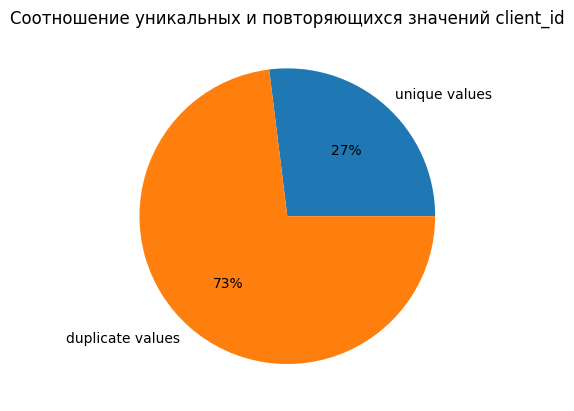

количество уникальных значений message_id:
		20940
количество уникальных значений message_id в общем количестве message_id:
		43.460%


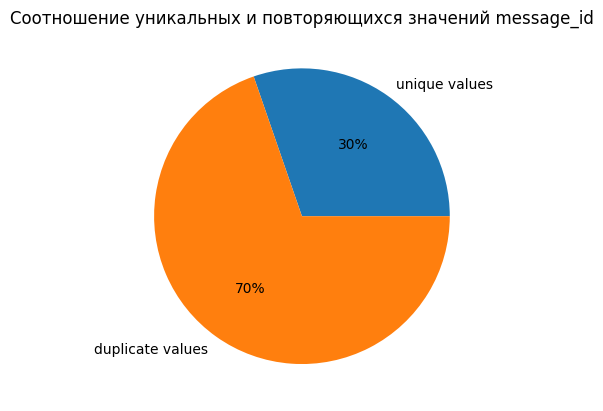

описание quantity:
		count    48182.000000
mean         1.017413
std          0.540592
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         50.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 15


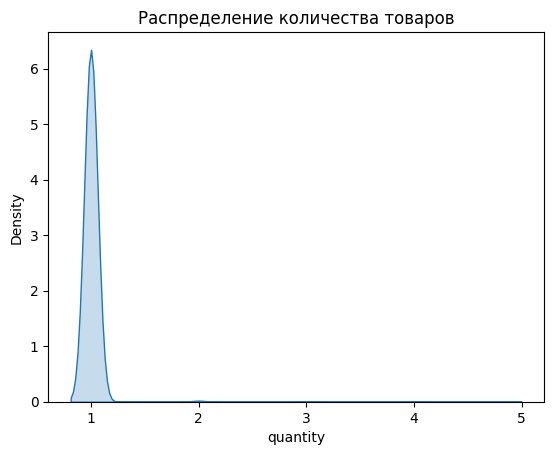

описание price:
		count    4.818200e+04
mean     2.791895e+04
std      4.492274e+04
min      0.000000e+00
25%      1.204250e+03
50%      9.998000e+03
75%      3.599800e+04
max      1.299998e+06
Name: price, dtype: float64
количество уникальных значений price: 4991


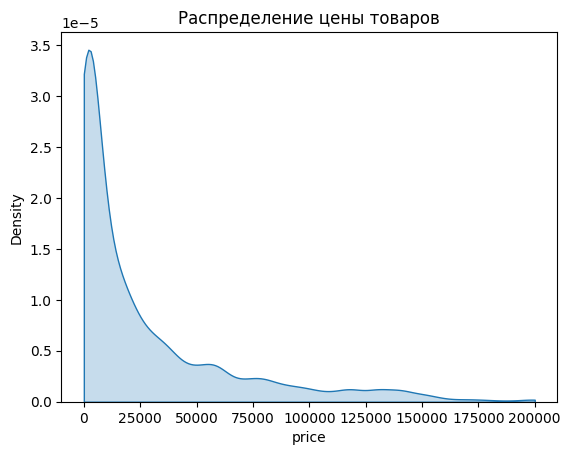

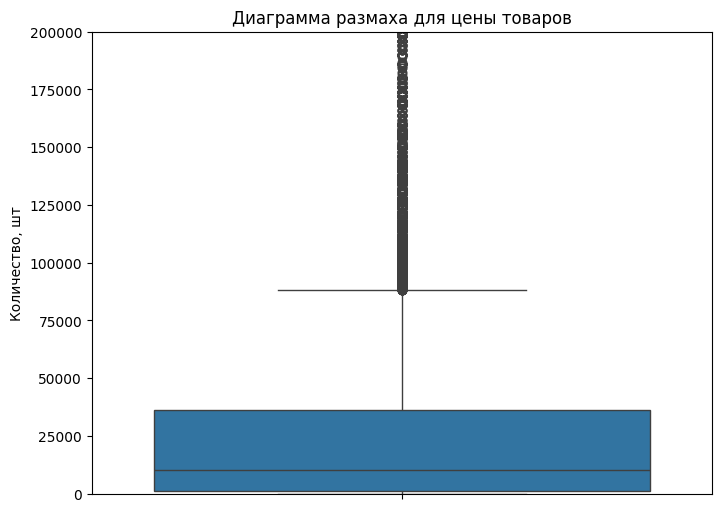

Первая запись в датафрейме: 2022-10-26 08:35:46
		Последняя запись в датафрейме: 2023-10-26 13:34:11


In [8]:
explorer_marketplace = DatasetExplorer(marketplace, y_lim=200000)
explorer_marketplace.explore_dataset()  # 48182

In [9]:
print(f"""Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
{(marketplace['created_at'] == marketplace['date'].dt.date).sum() / marketplace.shape[0] * 100:.0f}%""")

Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
100%


Удаление дублирующего признака

In [10]:
marketplace = marketplace.drop(['date'], axis=1)

Переименование признака для единообразия

In [11]:
marketplace.rename(columns={'created_at': 'date'}, inplace=True)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- количество полных дубликатов строк составляет около 5% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дальнейшем при агрегации;
- количество уникальных значений `client_id` составляет чуть больше трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
-  медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
-  в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price`обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- признаки `created_at` и `date` полностью совпадают, принимаю решение удалить `date`,
  <br>посколько собираюсь агрегировать покупки по каждому клиенту за день, т.к. Заказчика интересует
  <br>возвращение клиента через дни, а не часы.

### Apparel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
76684,1515915625587392652,1,3999.0,2023-06-10,1515915625759745007-13319-6483f58cb7103,bulk_message
42616,1515915625490379587,1,140.0,2023-06-15,1515915625490379587-13360-648b358f340d9,bulk_message
113609,1515915625637588327,1,2099.0,2022-11-11,1515915625491347724-7810-636e58f6bc6fe,bulk_message
11680,1515915625472647957,1,473.0,2023-03-25,1515915625472647957-11144-641ad29b4fcce,bulk_message
63945,1515915625607942826,1,2221.0,2023-09-16,1515915625468119694-13805-6503f3463a1d3,bulk_message


количество полных дубликатов строк: 59250


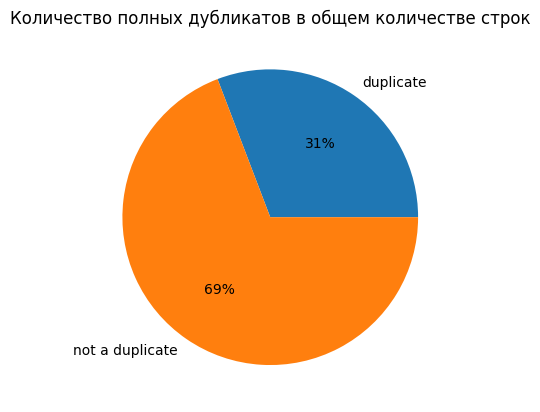

количество уникальных значений client_id:
		28891
количество уникальных значений client_id в общем количестве client_id:
		21.706%


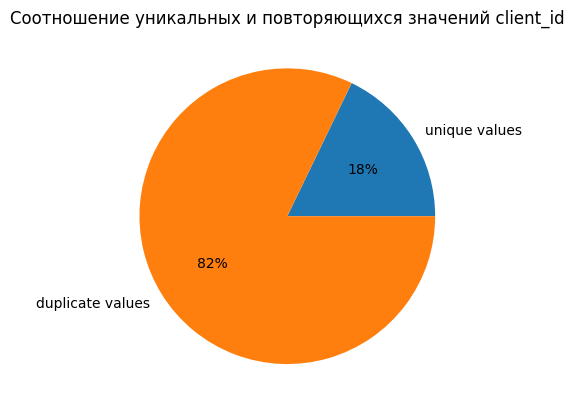

количество уникальных значений message_id:
		25426
количество уникальных значений message_id в общем количестве message_id:
		19.102%


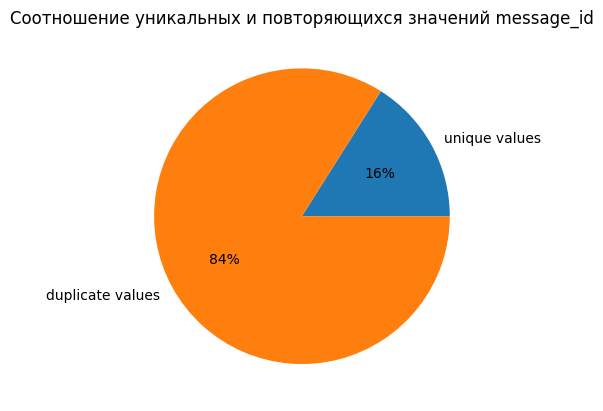

описание quantity:
		count    133104.000000
mean          1.004312
std           0.149315
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 12


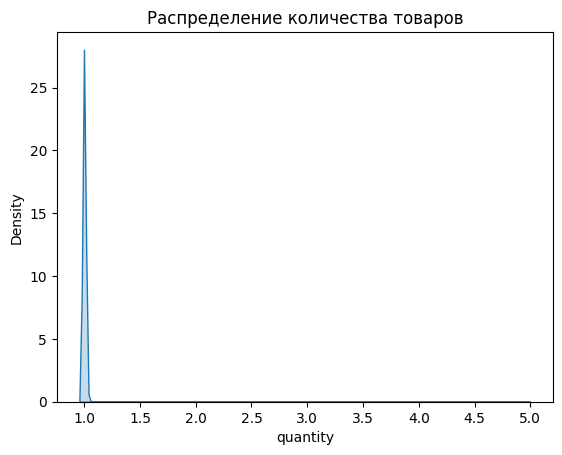

описание price:
		count    133104.000000
mean       1110.433067
std        1257.080854
min           1.000000
25%         280.000000
50%         799.000000
75%        1499.000000
max       63499.000000
Name: price, dtype: float64
количество уникальных значений price: 3335


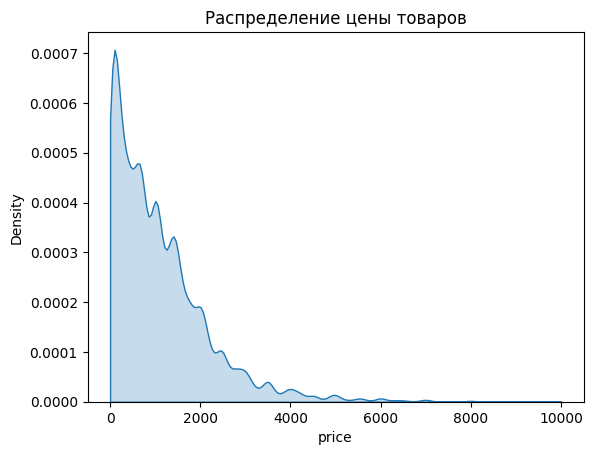

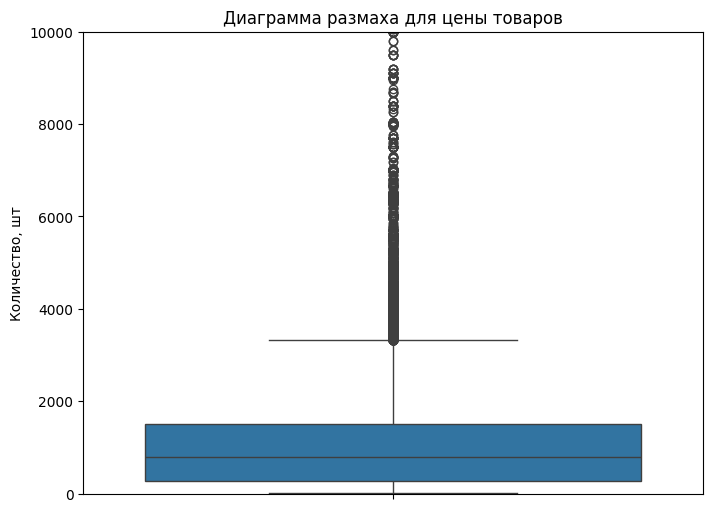

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-26 00:00:00


In [12]:
explorer_apparel = DatasetExplorer(apparel, y_lim=10000)
explorer_apparel.explore_dataset()  # 133104

In [13]:
print(f"""уникальные значения recommended_by:
{apparel['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    133104
Name: count, dtype: int64


Удаление признака recommended_by

In [14]:
apparel = apparel.drop(['recommended_by'], axis=1)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- количество полных дубликатов строк составляет около 30% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дельнейшем при агрегации;
- количество уникальных значений `client_id` составляет около 20% от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак,
  <br>как неинформативный.

### Gifts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


,client_id,quantity,price,date,message_id,recommended_by
270,1515915625913349570,1,4373.0,2023-03-31,1515915625913349570-11383-64243466be12e,bulk_message
702,1515915625997770678,1,47549.0,2023-08-18,1515915625997770678-14492-64df77a78ece8,bulk_message
578,1515915625849466437,1,46341.0,2023-06-01,1515915625849466437-13051-6478878d5d36a,bulk_message
333,1515915625835003865,1,26770.0,2023-05-22,1515915625835003865-12742-646b14f279890,bulk_message
287,1515915625941752698,1,1701.0,2023-03-23,1515915625932163842-11100-64185f9abfc8c,bulk_message


количество полных дубликатов строк: 56


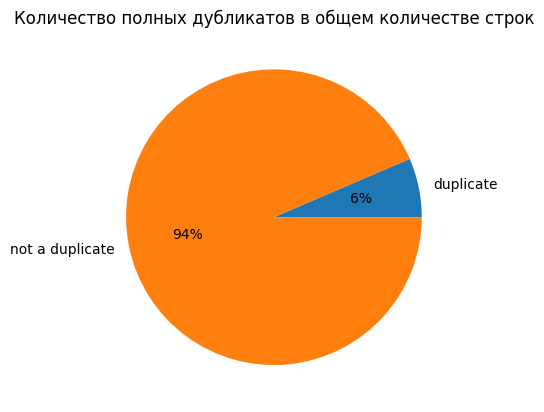

количество уникальных значений client_id:
		326
количество уникальных значений client_id в общем количестве client_id:
		40.197%


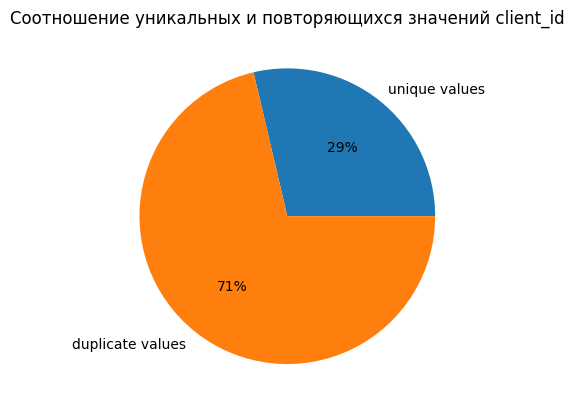

количество уникальных значений message_id:
		342
количество уникальных значений message_id в общем количестве message_id:
		42.170%


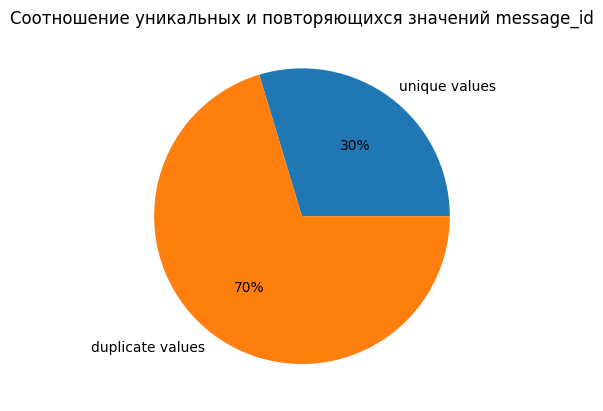

описание quantity:
		count    811.000000
mean       1.003699
std        0.060745
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 2


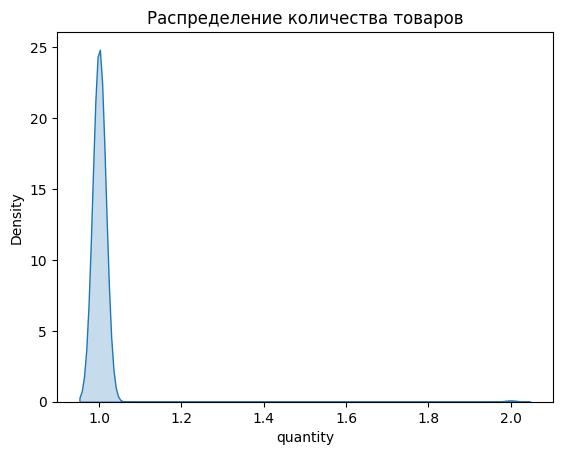

описание price:
		count       811.000000
mean      14468.795314
std       17774.341837
min         656.000000
25%        3878.000000
50%        7533.000000
75%       17938.000000
max      173586.000000
Name: price, dtype: float64
количество уникальных значений price: 598


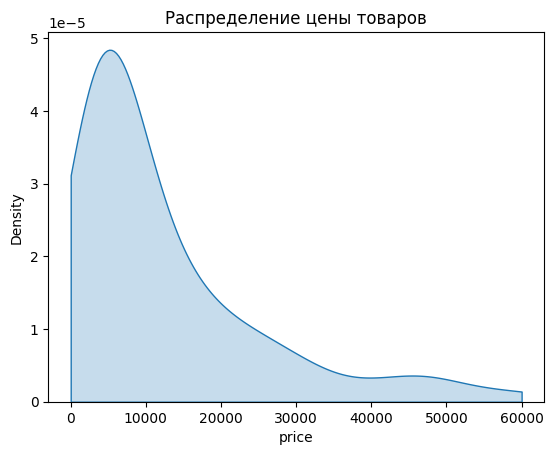

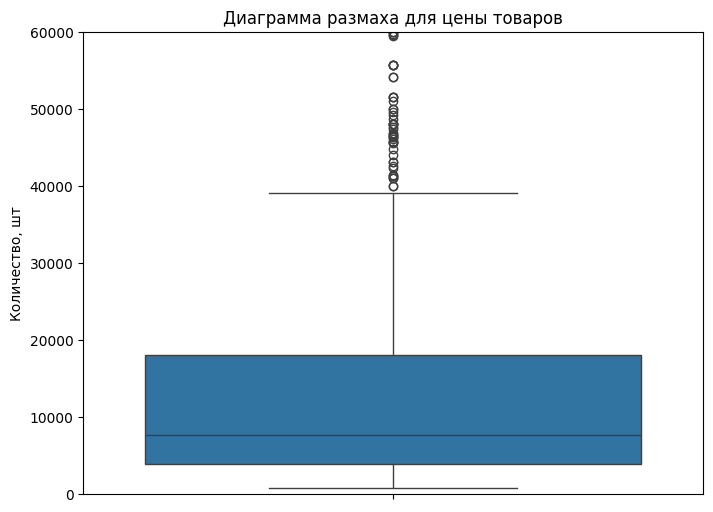

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-24 00:00:00


In [15]:
explorer_gifts = DatasetExplorer(gifts, y_lim=60000)
explorer_gifts.explore_dataset()  # 811

In [16]:
print(f"""уникальные значения recommended_by:
{gifts['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    811
Name: count, dtype: int64


Удаление признака recommended_by

In [17]:
gifts = gifts.drop(['recommended_by'], axis=1)

#### Выводы и наблюдения
- пропущенных значений в данных не обнаружено;
- количество полных дубликатов строк составляет около 6% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дельнейшем при агрегации;
- количество уникальных значений `client_id` составляет около трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- количество уникальных значений `message_id` составляет около трети от всех;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 24.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак,
  <br>как неинформативный.

## Предобработка, создание признаков

### Marketplace

interval columns not set, guessing: ['quantity', 'sum_price', 'count_unique_message_id', 'target', 'cumulative_sum', 'is_holiday']


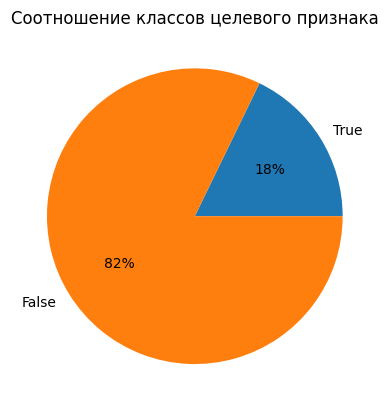

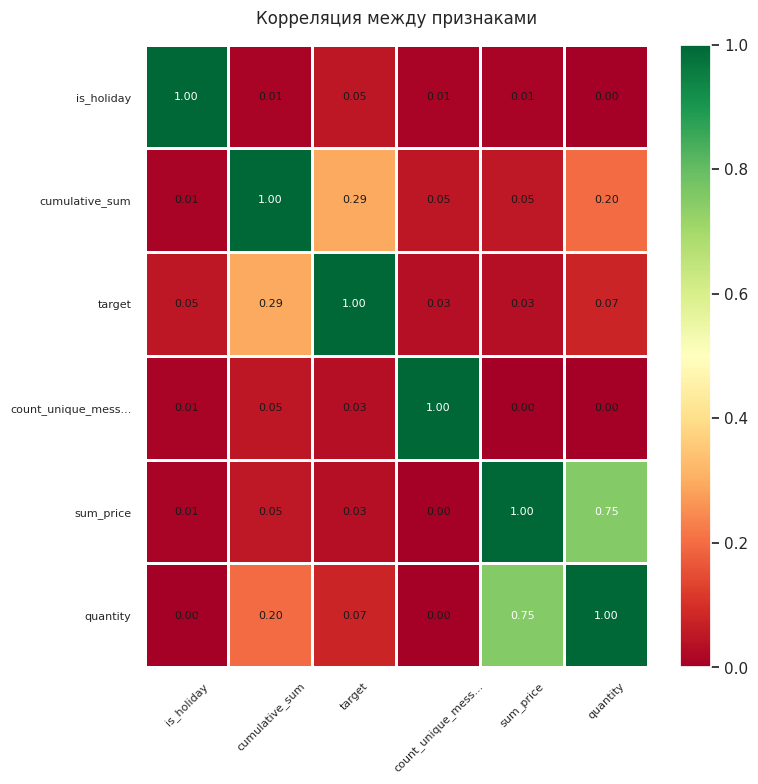

In [18]:
grouped_mp = explorer_marketplace.add_new_features(dataset=marketplace, holidays=holidays)

In [19]:
print("информация по данным после обработки:")
grouped_mp.info()

информация по данным после обработки:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21716 entries, 2022-10-26 to 2023-10-24
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                21716 non-null  int64  
 1   quantity                 21716 non-null  int64  
 2   sum_price                21716 non-null  float64
 3   count_unique_message_id  21716 non-null  int64  
 4   target                   21716 non-null  int64  
 5   cumulative_sum           21716 non-null  int64  
 6   is_holiday               21716 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.3 MB


In [20]:
print('фрагмент данных с демонстрацией расчёта целевого признака:')
grouped_mp[grouped_mp['client_id'] == 1515915625519851864]

фрагмент данных с демонстрацией расчёта целевого признака:


,client_id,quantity,sum_price,count_unique_message_id,target,cumulative_sum,is_holiday
date,,,,,,,
2023-03-03,1515915625519851864,2,7798.0,1,1,1,0
2023-03-07,1515915625519851864,1,7306.0,1,0,2,1
2023-07-31,1515915625519851864,1,20.0,1,0,1,0
2023-09-02,1515915625519851864,2,65998.0,1,0,1,1


### Apparel

interval columns not set, guessing: ['quantity', 'sum_price', 'count_unique_message_id', 'target', 'cumulative_sum', 'is_holiday']


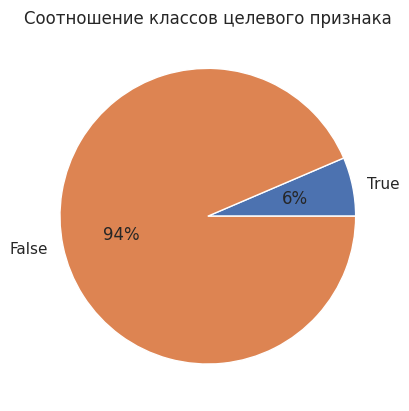

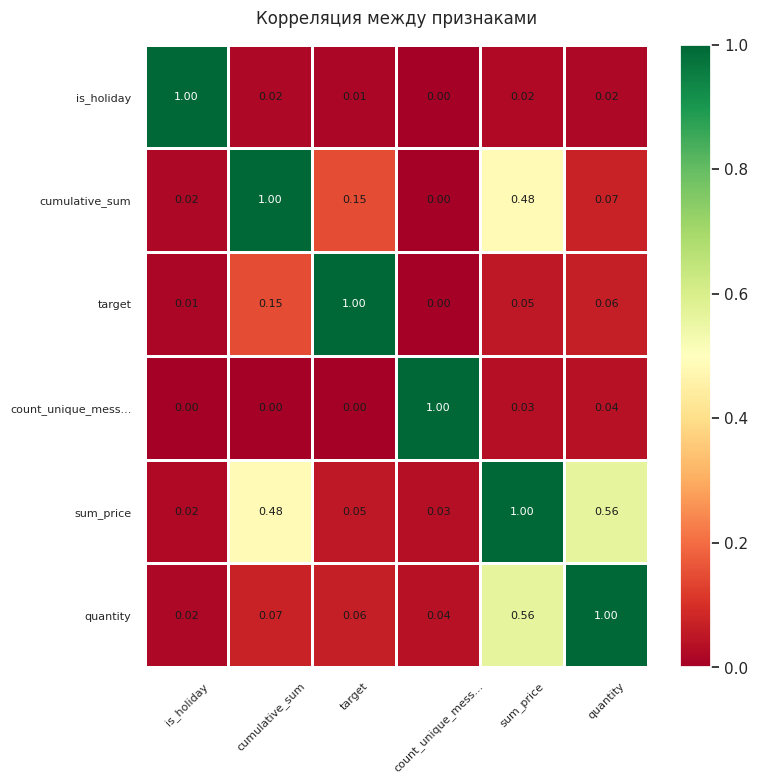

In [21]:
grouped_aprl = explorer_apparel.add_new_features(dataset=apparel, holidays=holidays)

In [22]:
print("информация по данным после обработки:")
grouped_aprl.info()

информация по данным после обработки:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32394 entries, 2022-10-26 to 2023-10-24
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                32394 non-null  int64  
 1   quantity                 32394 non-null  int64  
 2   sum_price                32394 non-null  float64
 3   count_unique_message_id  32394 non-null  int64  
 4   target                   32394 non-null  int64  
 5   cumulative_sum           32394 non-null  int64  
 6   is_holiday               32394 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 2.0 MB


In [23]:
print('фрагмент данных с демонстрацией расчёта целевого признака:')
grouped_aprl[grouped_aprl['client_id'] == 1515915625514003125]

фрагмент данных с демонстрацией расчёта целевого признака:


,client_id,quantity,sum_price,count_unique_message_id,target,cumulative_sum,is_holiday
date,,,,,,,
2022-12-14,1515915625514003125,2,798.0,1,1,1,0
2022-12-26,1515915625514003125,4,8398.0,1,0,2,0


### Gifts

interval columns not set, guessing: ['quantity', 'sum_price', 'count_unique_message_id', 'target', 'cumulative_sum', 'is_holiday']


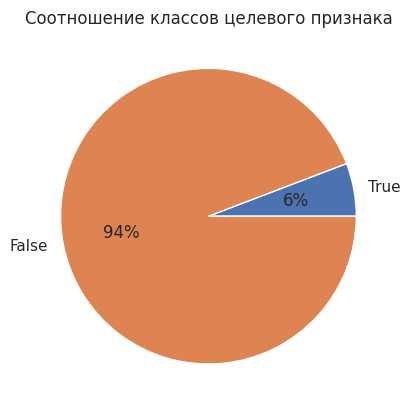

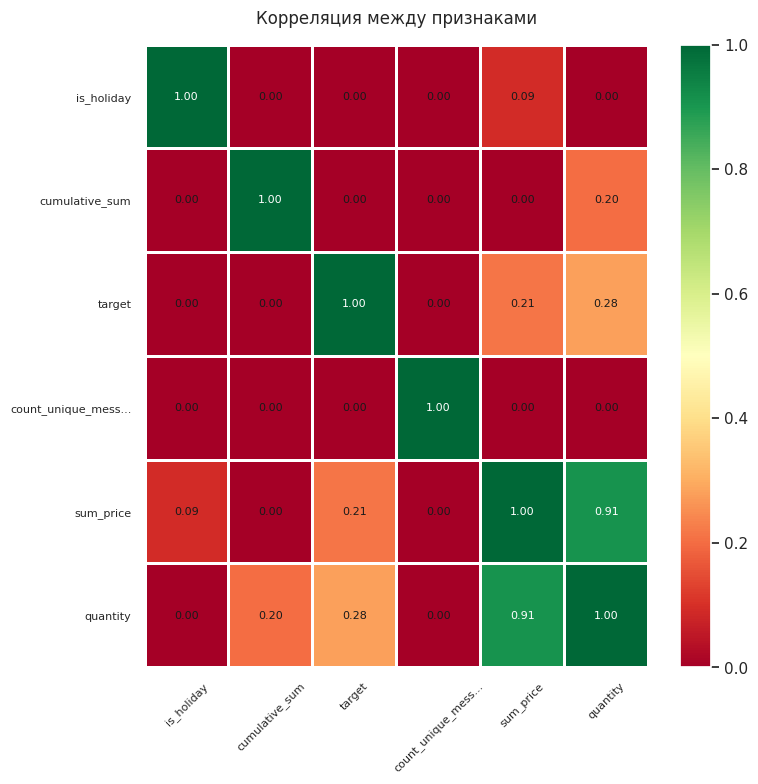

In [24]:
grouped_gft = explorer_gifts.add_new_features(dataset=gifts, holidays=holidays)

In [25]:
print("информация по данным после обработки:")
grouped_gft.info()

информация по данным после обработки:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2022-10-26 to 2023-09-23
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                345 non-null    int64  
 1   quantity                 345 non-null    int64  
 2   sum_price                345 non-null    float64
 3   count_unique_message_id  345 non-null    int64  
 4   target                   345 non-null    int64  
 5   cumulative_sum           345 non-null    int64  
 6   is_holiday               345 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 21.6 KB


In [26]:
print('фрагмент данных с демонстрацией расчёта целевого признака:')
grouped_gft[grouped_gft['client_id'] == 1515915625864700367]

фрагмент данных с демонстрацией расчёта целевого признака:


,client_id,quantity,sum_price,count_unique_message_id,target,cumulative_sum,is_holiday
date,,,,,,,
2022-12-26,1515915625864700367,1,19990.0,1,1,1,0
2023-01-06,1515915625864700367,7,32939.0,1,0,2,1


### Выводы и наблюдения
<br>В каждом датасете
- Произведена группировка по дням и клиентам;
- добавлен целевой признак `target`:
    - если в течение 30-ти дней произведена повторная покупка, то значение = 1
    - если покупки не случилось, то ставим нулевое значение
    - каждая повторная покупка обнуляет отсчёт по клиенту
- добавлен признак `cumulative_sum` кумулятивной суммы активностей в течение 30-ти дней;
- добавлен признак `is_holiday`, обозначающего праздничный или выходной день;
- удалены записи за последние 30 дней, т.к. за этот период нет возможности корректно посчитать таргет;
- установлена дата в индекс, датасет упорядочен по возрастанию;
- наблюдается большой дисбаланс классов;
- проверка корреляций между признаками показала отсутствие зависимостей с целевым признаком,
  <br>в наборе данных `gifts` наблюдается прямая связь между признаками `price` и `quantity`.

## EDA

### Marketplace

Проведение теста Дики-Фуллера для проверки ряда на стационарность
adf:  -9.198043897496502
p-value:  2.037337011354062e-15
Critical values:  {'1%': -3.4306518310347043, '5%': -2.8616733992749053, '10%': -2.566841004690704}
ряд стационарен, единичных корней нет


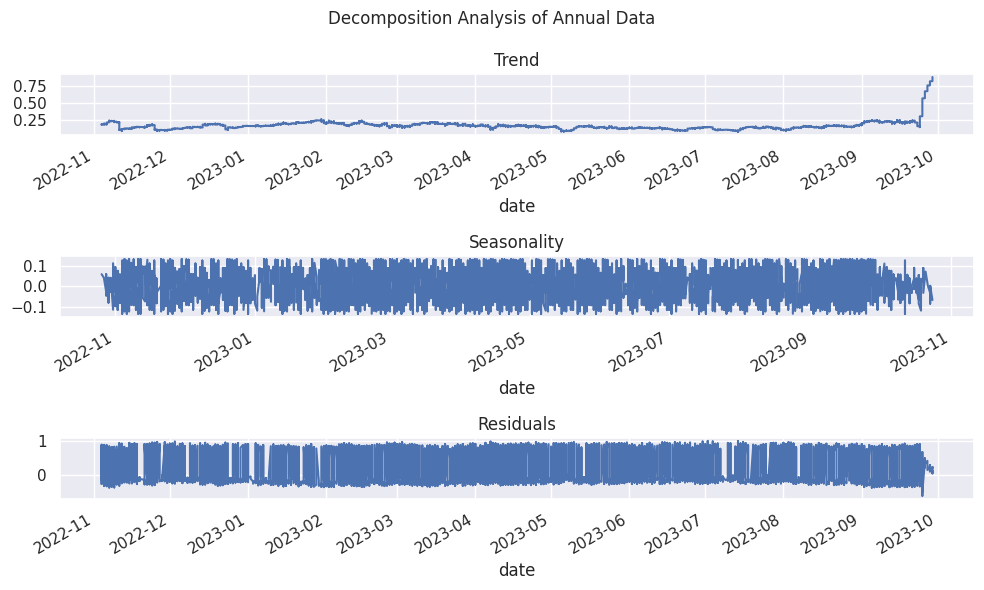

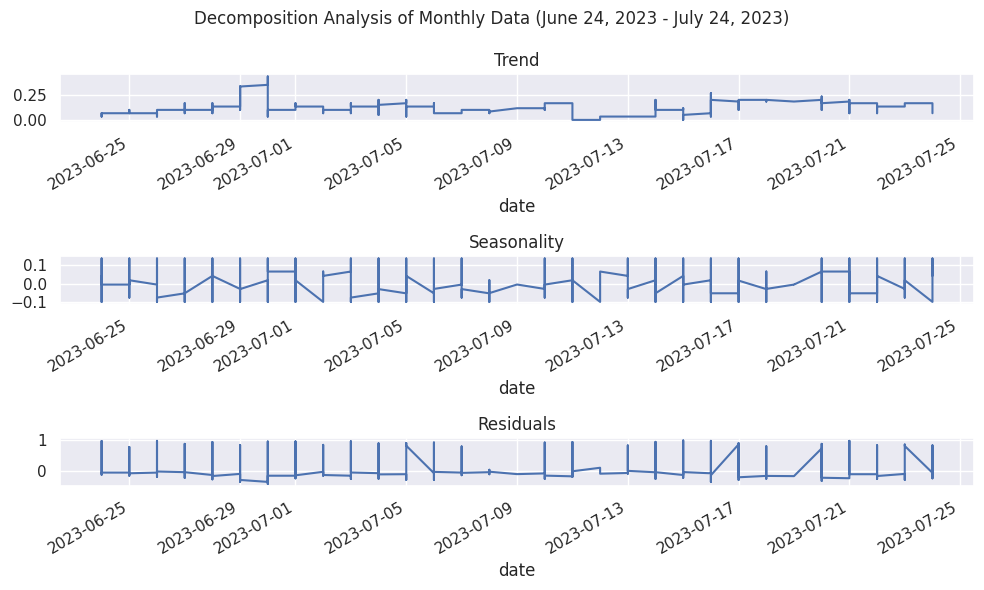

In [27]:
explorer_marketplace.seasonality_and_stationarity(grouped_mp, period_1=365, period_2=30)

### Apparel

Проведение теста Дики-Фуллера для проверки ряда на стационарность
adf:  -23.104647857486334
p-value:  0.0
Critical values:  {'1%': -3.4305521082525106, '5%': -2.8616293266236132, '10%': -2.5668175457942413}
ряд стационарен, единичных корней нет


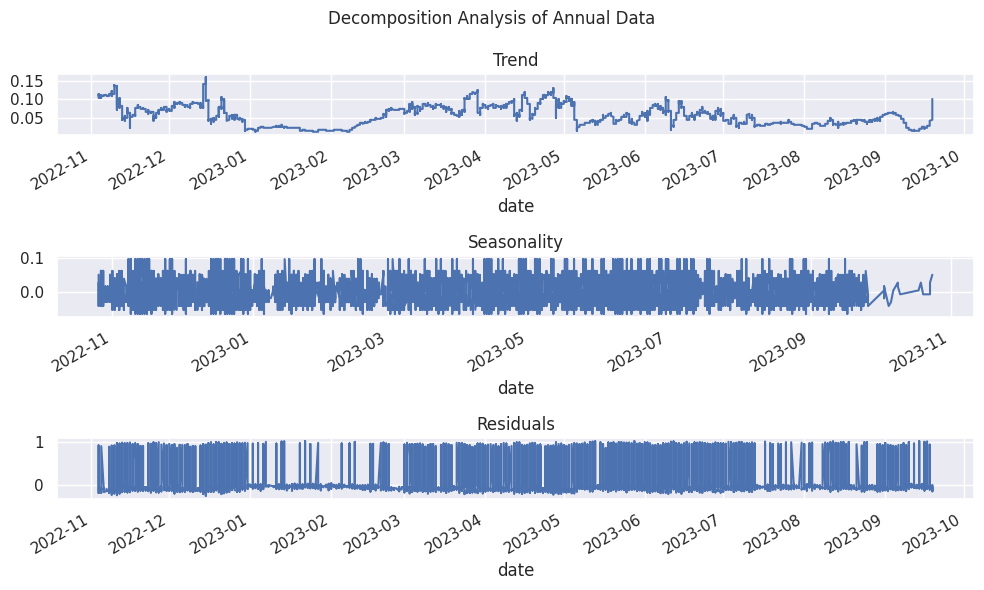

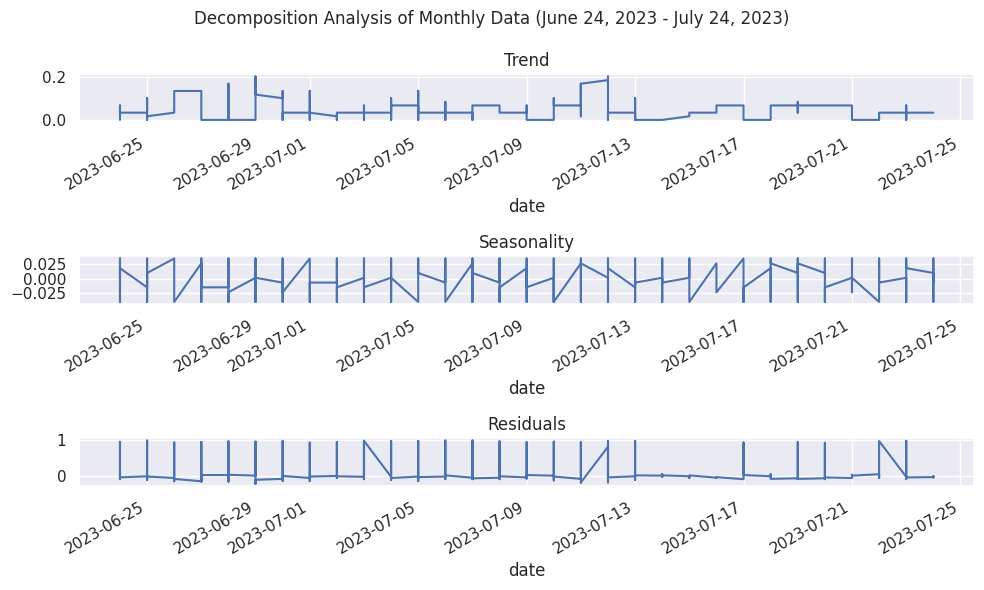

In [28]:
explorer_apparel.seasonality_and_stationarity(grouped_aprl, period_1=365, period_2=30)

### Gifts

Проведение теста Дики-Фуллера для проверки ряда на стационарность
adf:  -17.688799196702885
p-value:  3.5801169349813894e-30
Critical values:  {'1%': -3.4495033946549123, '5%': -2.8699787979596136, '10%': -2.5712658305164955}
ряд стационарен, единичных корней нет


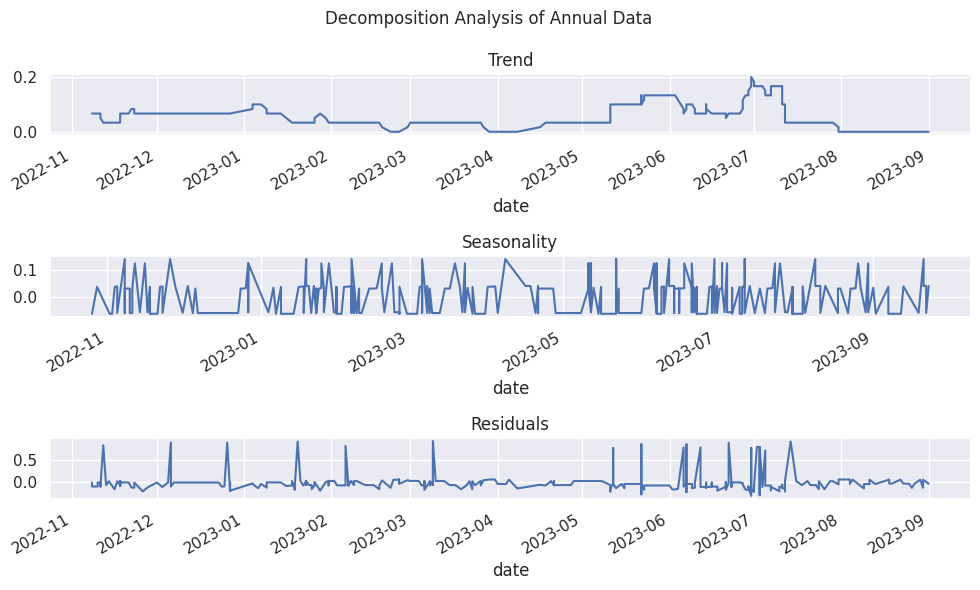

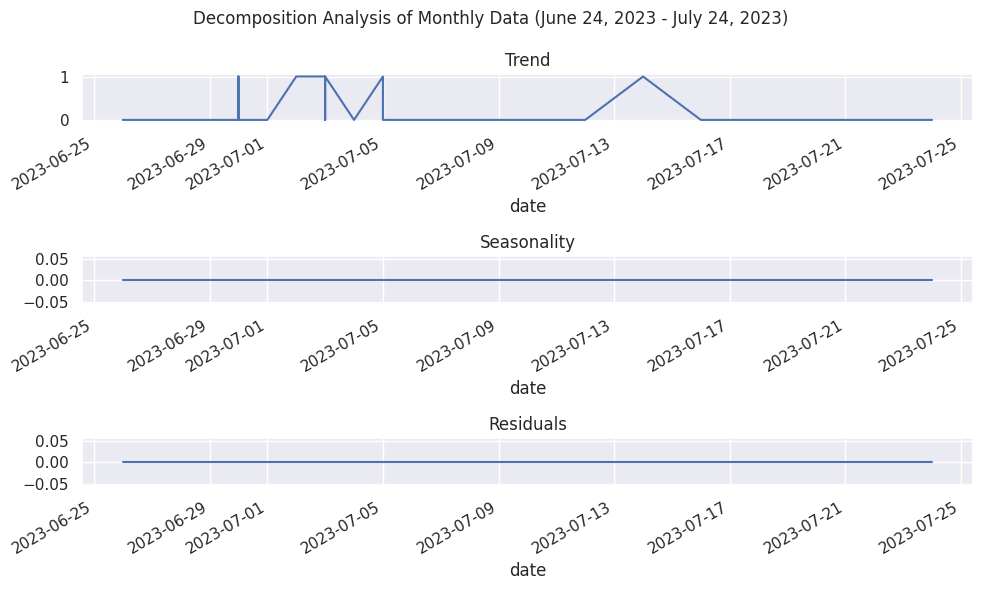

In [29]:
explorer_gifts.seasonality_and_stationarity(grouped_gft, period_1=30, period_2=1)

### Выводы и наблюдения
<br>По всем датасетам
- Сезонности не выявлено;
- трендов не выявлено;
- проведённый тест Дики-Фуллера позволяет предположить,
  <br>что предоставленные датасеты стационарны.

## Подготовка признаков к обучению моделей

### Marketplace

In [30]:
X_train_mp, X_test_mp, y_train_mp, y_test_mp, tscv_mp = explorer_marketplace.prepare_for_training(dataset=grouped_mp)

(19544, 6) (2172, 6) (19544,) (2172,)


### Apparel

In [31]:
X_train_apr, X_test_apr, y_train_apr, y_test_apr, tscv_apr = explorer_apparel.prepare_for_training(dataset=grouped_aprl)

(29154, 6) (3240, 6) (29154,) (3240,)


### Gifts

In [32]:
X_train_gf, X_test_gf, y_train_gf, y_test_gf, tscv_gf = explorer_gifts.prepare_for_training(dataset=grouped_gft)

(310, 6) (35, 6) (310,) (35,)


### Выводы и наблюдения
<br>По всем датасетам
- произведено масштабирование числовых признаков;
- произведено разделение данных на обучающий и тестовый наборы;
- создан объект `TimeSeriesSplit` для проведения кросс-валидации.

## Обучение моделей

### Marketplace

Лучшие параметры GridSearch: {'fit_intercept': False}
Лучшая оценка GridSearch: 0.38358801173636226
ROC-AUC: 0.6592663443095379
Precision: 0.35639097744360904
Recall: 0.3748813666561215


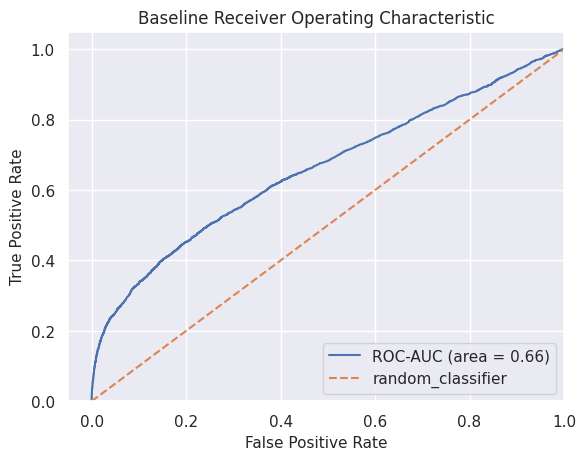

In [33]:
recall_baseline_mp, precision_baseline_mp, roc_auc_baseline_mp, baseline_mp = (
    explorer_marketplace.modeling_pipeline(model_name='Baseline', 
                                           X_train=X_train_mp, 
                                           y_train=y_train_mp, 
                                           tscv=tscv_mp,
                                           periods=X_train_mp.shape[0])
)

12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing


ROC-AUC: 0.5011953077571343
Precision: 0.16140662556170968
Recall: 0.9772223979753243


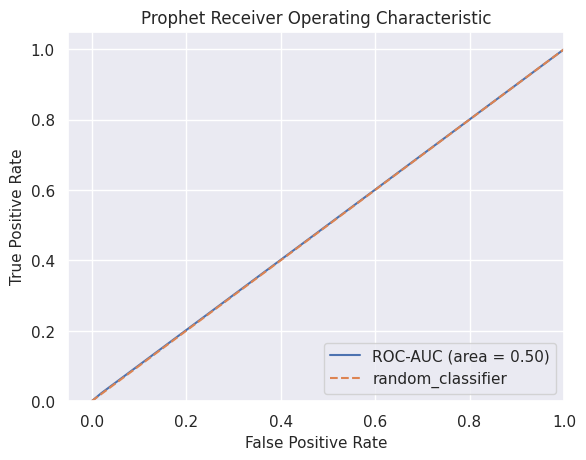

In [34]:
recall_prophet_mp, precision_prophet_mp, roc_auc_prophet_mp, model_prophet_mp = (
    explorer_marketplace.modeling_pipeline(model_name='Prophet', 
                                           X_train=X_train_mp, 
                                           y_train=y_train_mp, 
                                           tscv=tscv_mp,
                                           periods=X_train_mp.shape[0])
)

Learning rate set to 0.03666
0:	total: 56.6ms	remaining: 56.5s
100:	total: 401ms	remaining: 3.57s
200:	total: 718ms	remaining: 2.85s
300:	total: 1.05s	remaining: 2.45s
400:	total: 1.4s	remaining: 2.08s
500:	total: 1.73s	remaining: 1.73s
600:	total: 2.07s	remaining: 1.38s
700:	total: 2.42s	remaining: 1.03s
800:	total: 2.76s	remaining: 686ms
900:	total: 3.15s	remaining: 346ms
999:	total: 3.53s	remaining: 0us
ROC-AUC: 0.7215945638358664
Precision: 0.8184397163120567
Recall: 0.18253717178108195


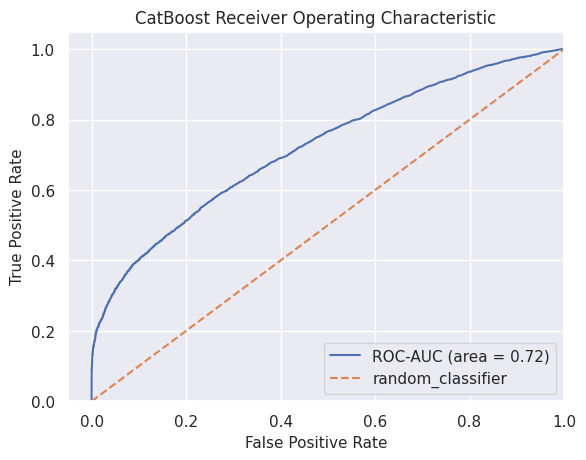

In [35]:
recall_cb_mp, precision_cb_mp, roc_auc_cb_mp, model_cb_mp = (
    explorer_marketplace.modeling_pipeline(
        model_name='CatBoost', 
        X_train=X_train_mp, 
        y_train=y_train_mp, 
        tscv=tscv_mp,
        periods=X_train_mp.shape[0])
)

### Apparel

Лучшие параметры GridSearch: {'fit_intercept': False}
Лучшая оценка GridSearch: 0.472400677333507
ROC-AUC: 0.5916456128162535
Precision: 0.10353456365342509
Recall: 0.34018499486125386


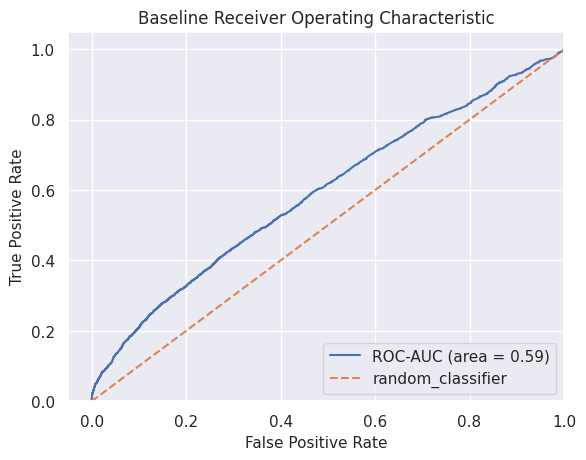

In [36]:
recall_baseline_apr, precision_baseline_apr, roc_auc_baseline_apr, baseline_apr = (
    explorer_marketplace.modeling_pipeline(model_name='Baseline', 
                                           X_train=X_train_apr,
                                           y_train=y_train_apr,
                                           tscv=tscv_apr,
                                           periods=X_train_apr.shape[0])
)

12:06:40 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing


ROC-AUC: 0.5
Precision: 0.0
Recall: 0.0


/home/denis/Documents/main_venv/mp_research/mp_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


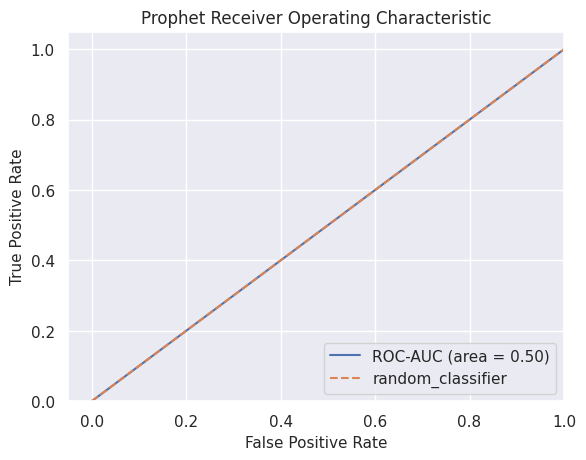

In [37]:
recall_prophet_apr, precision_prophet_apr, roc_auc_prophet_apr, model_prophet_apr = (
    explorer_marketplace.modeling_pipeline(model_name='Prophet', 
                                           X_train=X_train_apr, 
                                           y_train=y_train_apr, 
                                           tscv=tscv_apr,
                                           periods=X_train_apr.shape[0])
)

Learning rate set to 0.043487
0:	total: 10.4ms	remaining: 10.4s
100:	total: 426ms	remaining: 3.79s
200:	total: 810ms	remaining: 3.22s
300:	total: 1.21s	remaining: 2.8s
400:	total: 1.61s	remaining: 2.4s
500:	total: 2.08s	remaining: 2.07s
600:	total: 2.48s	remaining: 1.64s
700:	total: 2.94s	remaining: 1.25s
800:	total: 3.36s	remaining: 836ms
900:	total: 3.78s	remaining: 415ms
999:	total: 4.18s	remaining: 0us
ROC-AUC: 0.6975847798679609
Precision: 1.0
Recall: 0.04933196300102775


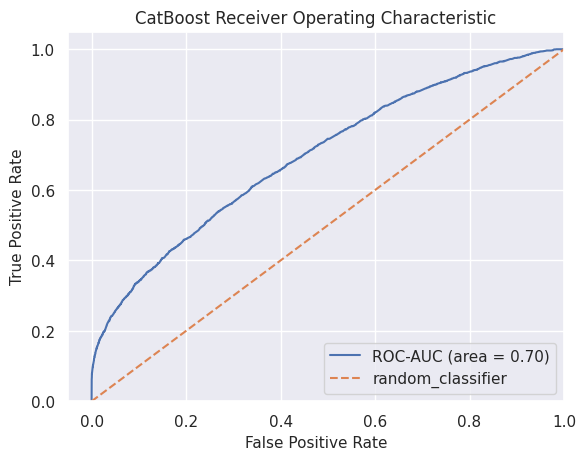

In [38]:
recall_cb_apr, precision_cb_apr, roc_auc_cb_apr, model_cb_apr = (
    explorer_marketplace.modeling_pipeline(
        model_name='CatBoost', 
        X_train=X_train_apr, 
        y_train=y_train_apr, 
        tscv=tscv_apr,
        periods=X_train_apr.shape[0])
)

### Gifts

/home/denis/Documents/main_venv/mp_research/mp_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/denis/Documents/main_venv/mp_research/mp_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/denis/Documents/main_venv/mp_research/mp_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Лучшие параметры GridSearch: {'fit_intercept': False}
Лучшая оценка GridSearch: 0.4916666666666667
ROC-AUC: 0.6679310344827586
Precision: 0.12380952380952381
Recall: 0.65


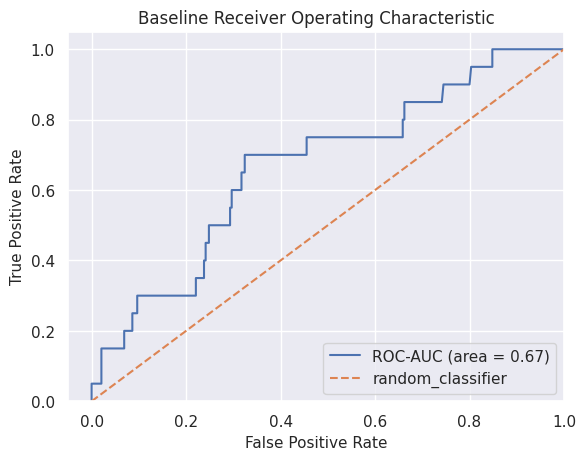

In [39]:
recall_baseline_gf, precision_baseline_gf, roc_auc_baseline_gf, baseline_gf = (
    explorer_marketplace.modeling_pipeline(model_name='Baseline', 
                                           X_train=X_train_gf, 
                                           y_train=y_train_gf, 
                                           tscv=tscv_gf,
                                           periods=X_train_gf.shape[0])
)

12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
/home/denis/Documents/main_venv/mp_research/mp_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC: 0.5
Precision: 0.0
Recall: 0.0


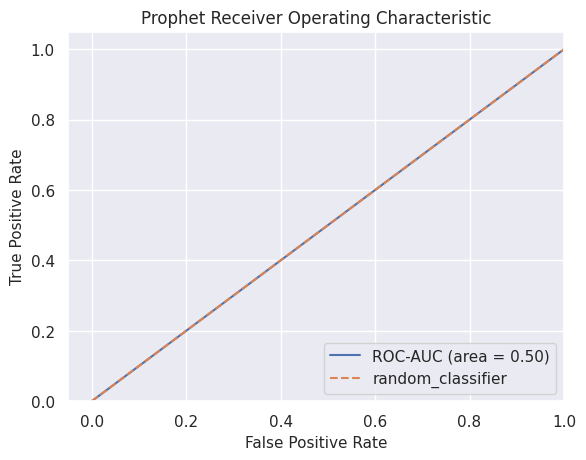

In [40]:
recall_prophet_gf, precision_prophet_gf, roc_auc_prophet_gf, model_prophet_gf = (
    explorer_marketplace.modeling_pipeline(model_name='Prophet', 
                                           X_train=X_train_gf,
                                           y_train=y_train_gf, 
                                           tscv=tscv_gf,
                                           periods=X_train_gf.shape[0])
)

Learning rate set to 0.006248
0:	total: 852us	remaining: 852ms
100:	total: 87.7ms	remaining: 781ms
200:	total: 163ms	remaining: 646ms
300:	total: 245ms	remaining: 568ms
400:	total: 317ms	remaining: 473ms
500:	total: 391ms	remaining: 389ms
600:	total: 469ms	remaining: 311ms
700:	total: 545ms	remaining: 232ms
800:	total: 620ms	remaining: 154ms
900:	total: 705ms	remaining: 77.4ms
999:	total: 784ms	remaining: 0us
ROC-AUC: 0.9190517241379311
Precision: 1.0
Recall: 0.15


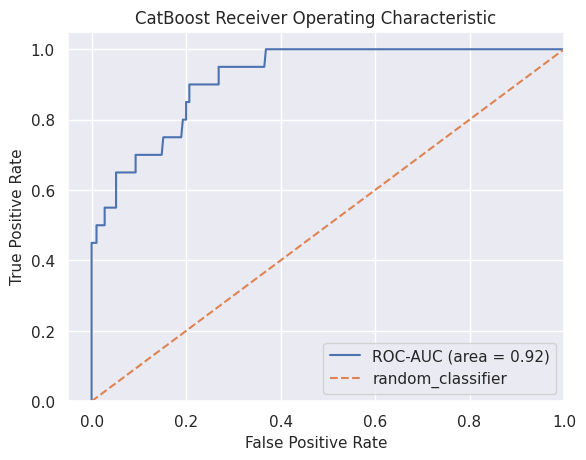

In [41]:
recall_cb_gf, precision_cb_gf, roc_auc_cb_gf, model_cb_gf = (
    explorer_marketplace.modeling_pipeline(
        model_name='CatBoost', 
        X_train=X_train_gf, 
        y_train=y_train_gf, 
        tscv=tscv_gf,
        periods=X_train_gf.shape[0])
)

### Выводы и наблюдения
- для каждого магазина обучены три модели:
  - Logistic Regression (Baseline), FB Prophet, Catboost
- получены метрики `roc-auc`, `recall`, `precision`
- визуализирован процесс обучения

## Выбор лучшей модели

### Marketplace

In [42]:
dict_sum_mp = {'Baseline': [recall_baseline_mp, precision_baseline_mp, roc_auc_baseline_mp],
               'Catboost': [recall_cb_mp, precision_cb_mp, roc_auc_cb_mp],
               'Prophet': [recall_prophet_mp, precision_prophet_mp, roc_auc_prophet_mp]}
marketplace_summary = (
    pd.DataFrame.from_dict(dict_sum_mp,
                           orient='index',
                           columns=["recall",
                                    "precision",
                                    "roc-auc"])
    .reset_index()
    .rename(columns={'index': 'model'})
)
marketplace_summary.sort_values('recall', ascending=False).reset_index(drop=True)

,model,recall,precision,roc-auc
0,Prophet,0.977222,0.161407,0.501195
1,Baseline,0.374881,0.356391,0.659266
2,Catboost,0.182537,0.818440,0.721595


Проверка качества лучшей модели на отложенной выборке

ROC-AUC на тестовой выборке: 0.71
Precision на тестовой выборке: 0.91
Recall на тестовой выборке: 0.2


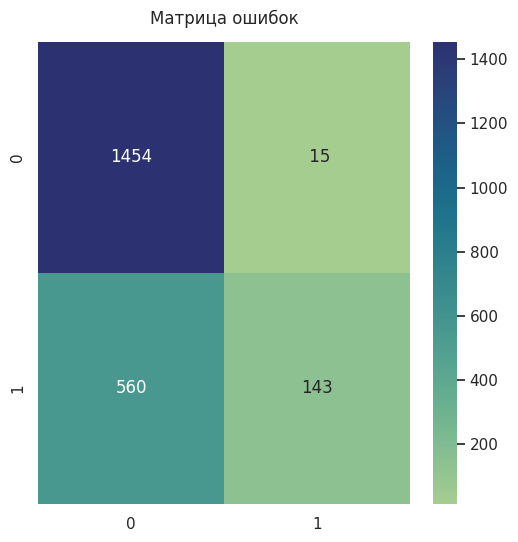

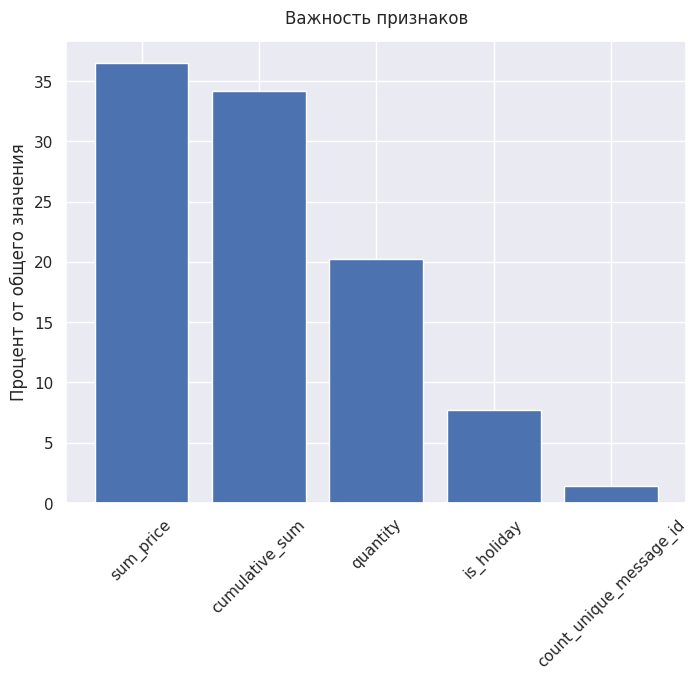

In [43]:
explorer_marketplace.test_best_model(model_cb_mp, X_train_mp, X_test_mp, y_test_mp)

### Apparel

In [44]:
dict_sum_apr = {'Baseline': [recall_baseline_apr, precision_baseline_apr, roc_auc_baseline_apr],
                'Catboost': [recall_cb_apr, precision_cb_apr, roc_auc_cb_apr],
                'Prophet': [recall_prophet_apr, precision_prophet_apr, roc_auc_prophet_apr]}
apparel_summary = (
    pd.DataFrame.from_dict(dict_sum_apr,
                           orient='index',
                           columns=["recall",
                                    "precision",
                                    "roc-auc"])
    .reset_index()
    .rename(columns={'index': 'model'})
)
apparel_summary.sort_values('recall', ascending=False).reset_index(drop=True)

,model,recall,precision,roc-auc
0,Baseline,0.340185,0.103535,0.591646
1,Catboost,0.049332,1.000000,0.697585
2,Prophet,0.000000,0.000000,0.500000


Проверка качества лучшей модели на отложенной выборке

ROC-AUC на тестовой выборке: 0.58
Precision на тестовой выборке: 0.5
Recall на тестовой выборке: 0.01


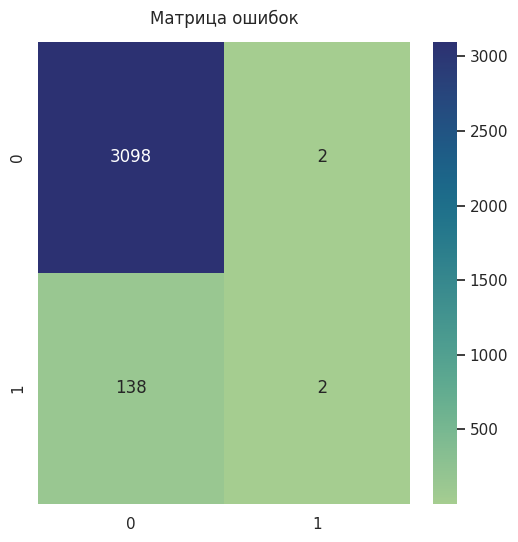

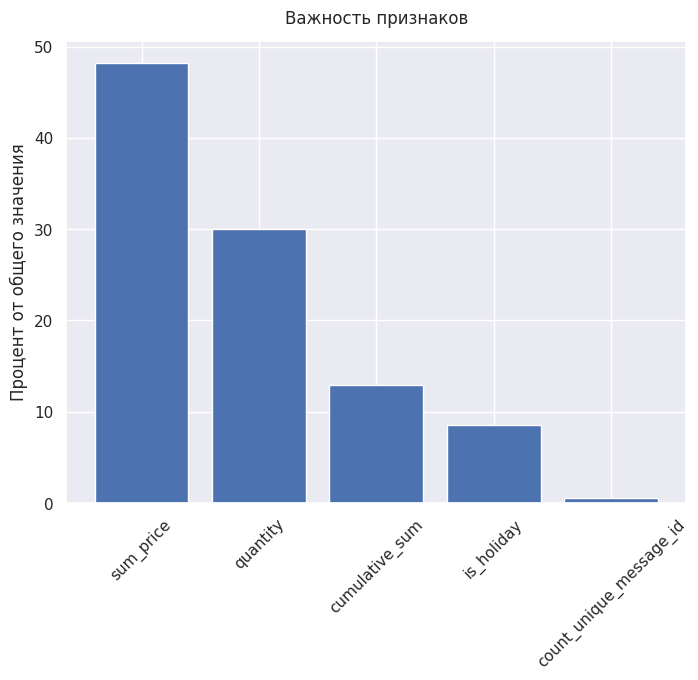

In [45]:
explorer_marketplace.test_best_model(model_cb_apr, X_train_apr, X_test_apr, y_test_apr)

### Gifts

In [46]:
dict_sum_gft = {'Baseline': [recall_baseline_gf, precision_baseline_gf, roc_auc_baseline_gf],
                'Catboost': [recall_cb_gf, precision_cb_gf, roc_auc_cb_gf],
                'Prophet': [recall_prophet_gf, precision_prophet_gf, roc_auc_prophet_gf]}
gifts_summary = (
    pd.DataFrame.from_dict(dict_sum_gft,
                           orient='index',
                           columns=["recall",
                                    "precision",
                                    "roc-auc"])
    .reset_index()
    .rename(columns={'index': 'model'})
)
gifts_summary.sort_values('recall', ascending=False).reset_index(drop=True)

,model,recall,precision,roc-auc
0,Baseline,0.65,0.12381,0.667931
1,Catboost,0.15,1.00000,0.919052
2,Prophet,0.00,0.00000,0.500000


Проверка качества лучшей модели на отложенной выборке

In [47]:
explorer_marketplace.test_best_model(model_cb_gf, X_train_gf, X_test_gf, y_test_gf)

Невозможно посчитать метрики - в данных присутствует только один класс


Сохранение зависимостей

In [48]:
!pip freeze > requirements.txt

## Заключение
Отчёт по выполненным в ходе исследования шагам

### Загрузка данных и ознакомление с ними
Шаг выполнен полностью, трудностей не возникло.
- данные загружены при помощи модуля `pandas`;
- проведено исследование на наличие пропусков;
- данные проверены на повторы строк;
- выявлено количество уникальных клиентов в предоставленных данных;
- изучены признаки количества и цен;
- проверен временной интервал, в течение которого проводились наблюдения;
- датасеты очищены от неинформативных признаков.

### Предобработка и создание новых признаков

Шаг выполнен полностью, трудностей не возникло.

- Произведена группировка по дням и клиентам;
- добавлен целевой признак `target`;
- добавлены признаки `cumulative_sum`, `is_holiday`;
- удалены записи за последние 30 дней;
- проанализирован баланс классов;
- произведён анализ корреляций между признаками.

### Анализ сезонности и стационарности
Шаг выполнен на 100%, трудностей не возникло.

- Произведено разложение временного ряда на тренд, сезонность и остатки;
- проведён тест Дики-Фуллера для заключения о стационарности.

### Подготовка признаков к обучению моделей

Шаг выполнен полностью, трудностей при выполнении не возникло.
- произведено масштабирование числовых признаков;
- произведено разделение данных на обучающий и тестовый наборы.

### Обучение моделей

<br>При обучении модели возникли трудности с получением результатов.
<br>Появились сомнения в корректности применённого подхода.
<br>Есть идея: сделать обучение в цикле по каждому клиенту,
<br>но при первом запуске это заняло достаточно много времени
<br>без получения результата.

- для каждого магазина обучены три модели: `Logistic Regression` (Baseline), `FB Prophet`, `Catboost`;
- получены метрики `roc-auc`, `recall`, `precision`;
- визуализирован процесс обучения.

### Выбор лучшей модели

Шаг выполнен полность, трудностей не возникло.

- Модели выбирались по оптимальному соотношению трёх метрик:
  - для маркетплейса и магазина одежды наилучшим образом себя показала модель `Catboost`
  - для построения прогнозов для магазина подарков пока можно не использовать мощности машинного обучения;
- матрицы ошибок показали, что модель хорошо определяет класс 0 и часто ошибается в 1;
- три наиболее важных для модели признака - `sum_price`, `quantity`, `cumulative_sum`.

По итогам исследования можно сделать заключение, что наиболее подходящей моделью для решения
<br>поставленной задачи Заказчика является модель градиентного бустинга `CatBoost`